## Regularized parallel and cascaded approaches using EFWI
Authors: Ulises Berman & Omar Saad Aly

In this notebook, the density parameter is updated via Gardner's Relation instead of with the inversion process, using EFWI.

In [1]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import deepwave
from deepwave import elastic
import random

/home/bermanu/Ulises/miniconda3/envs/ElasticSiameseFWI/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')
print(device)

cuda


In [3]:
# Print which device is used
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA TITAN RTX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

set_seed(0)   

True

In [5]:
####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 8                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = [20,20]         # step interval along x/z direction
dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 94                   # model shape of z dimension (depth) Seam Arid
ny        = 400                   # model shape of y dimension Seam Arid
vmodel_dim = np.array([nz, ny])

total_t   = 6                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
pml_width  = [10,10,0,10]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)
num_shots = 30                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 400       # number of receivers per shot
source_spacing = np.floor( ny / (num_shots))                         # space intervel between neigbouring sources
receiver_spacing = np.floor( ny / (num_receivers_per_shot))         # space intervel between neigbouring receivers
source_depth = 2               # the index depth of sources, default is 0 
receiver_depth = 0              # the index depths of receivers, default is 0

data_path = 'data/over_94_400.bin'

fwi_result = 'results/Overthrust_noise/'
# Loading the true model
base_true_vp = loadtruemodel(data_path, num_dims, vmodel_dim)
# Find where the water velocity ends and clip the models from that points
# model_vp, model_init_vp = loadinitmodel(initfile,device)
# The model will be updated during FWI
base_true_vs = vp_to_vs(base_true_vp)

base_true_rho = vp_to_rho(base_true_vp)*1000  # Convert to kg/m^3

# Convert models to numpy
base_true_vp = base_true_vp.cpu().numpy()
base_true_vs = base_true_vs.cpu().numpy()
base_true_rho = base_true_rho.cpu().numpy()

# Perturb velocity models
monitor_true_vp  = perturb_velocity_model(base_true_vp, center = (55, 110),lateral_extent = 30,vertical_layer_width = 4,
    max_vertical_extent_dilation = 60,compaction_magnitude = 250,dilation_magnitude = 120)
monitor_true_vp  = perturb_velocity_model(monitor_true_vp, center = (78, 310),lateral_extent = 40,vertical_layer_width = 5,
    max_vertical_extent_dilation = 70,compaction_magnitude = -250,dilation_magnitude = -120)

monitor_true_vs  = perturb_velocity_model(base_true_vs, center = (55, 110),lateral_extent = 30,vertical_layer_width = 4,
    max_vertical_extent_dilation = 60,compaction_magnitude = 250/np.sqrt(3),dilation_magnitude = 120/np.sqrt(3))
monitor_true_vs  = perturb_velocity_model(monitor_true_vs, center = (78, 310),lateral_extent = 40,vertical_layer_width = 5,
    max_vertical_extent_dilation = 70,compaction_magnitude = -250/np.sqrt(3),dilation_magnitude = -120/np.sqrt(3))

monitor_true_rho  = perturb_velocity_model(base_true_rho, center = (55, 110),lateral_extent = 30,vertical_layer_width = 4,
    max_vertical_extent_dilation = 60,compaction_magnitude = 40,dilation_magnitude = 16)
monitor_true_rho  = perturb_velocity_model(monitor_true_rho, center = (78, 310),lateral_extent = 40,vertical_layer_width = 5,
    max_vertical_extent_dilation = 70,compaction_magnitude = -40,dilation_magnitude = -16)


# Convert models to tensors and put them to device
base_true_vp = torch.from_numpy(base_true_vp).float().to(device)
base_true_rho = torch.from_numpy(base_true_rho).float().to(device)
base_true_vs = torch.from_numpy(base_true_vs).float().to(device)

# Convert models to tensors but keep them on CPU for now
monitor_true_vp = torch.from_numpy(monitor_true_vp).float()
monitor_true_rho = torch.from_numpy(monitor_true_rho).float()
monitor_true_vs = torch.from_numpy(monitor_true_vs).float()

In [6]:
# # Shift the value range
base_true_vp = denormalize_vp(normalize_vp(base_true_vp, vmin=base_true_vp.min(), vmax=base_true_vp.max()))
base_true_vs = denormalize_vs(normalize_vs(base_true_vs, vmin=base_true_vs.min(), vmax=base_true_vs.max()))
base_true_rho = denormalize_rho(normalize_rho(base_true_rho, vmin=base_true_rho.min(), vmax=base_true_rho.max()))

 # Shift the value range
monitor_true_vp = denormalize_vp(normalize_vp(monitor_true_vp, vmin=monitor_true_vp.min(), vmax=monitor_true_vp.max()))
monitor_true_vs = denormalize_vs(normalize_vs(monitor_true_vs, vmin=monitor_true_vs.min(), vmax=monitor_true_vs.max()))
monitor_true_rho = denormalize_rho(normalize_rho(monitor_true_rho, vmin=monitor_true_rho.min(), vmax=monitor_true_rho.max()))

# Smoothed initial model
model_vp = torch.from_numpy(gaussian_filter(base_true_vp.detach().cpu().numpy(), sigma=[15,30])).to(device)
model_vs = torch.from_numpy(gaussian_filter(base_true_vs.detach().cpu().numpy(), sigma=[15,30])).to(device)
model_rho = torch.from_numpy(gaussian_filter(base_true_rho.detach().cpu().numpy(), sigma=[15,30])).to(device)

# Loading the true model
model_init_vp = model_vp
model_init_vp = model_init_vp.detach().cpu()
# The model will be updated during FWI
model_vp = torch.nn.Parameter(model_vp)

# Loading the true model
model_init_vs = model_vs
model_init_vs = model_init_vs.detach().cpu()
# The model will be updated during FWI
model_vs = torch.nn.Parameter(model_vs)

# Loading the true model
model_init_rho = model_rho
model_init_rho = model_init_rho.detach().cpu()
# The model will be updated during FWI
model_rho.requires_grad_(False);
# model_rho = torch.nn.Parameter(model_rho)

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/ElasticSiameseFWI-pub/utils/utils.py:839: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


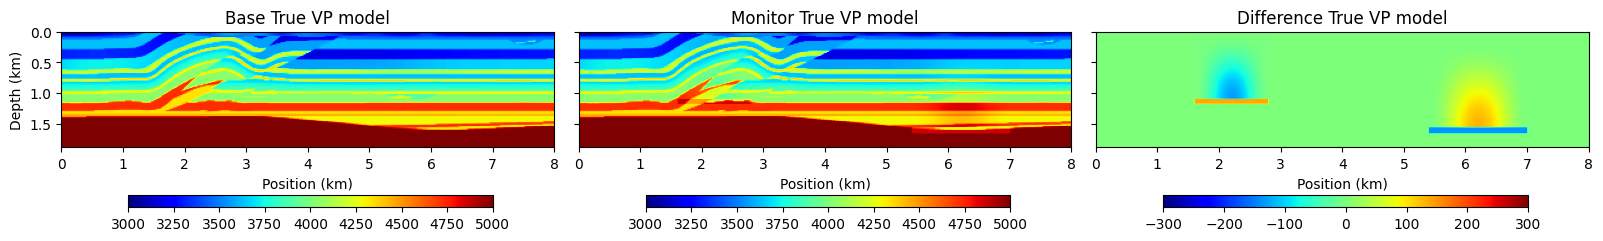

In [7]:
plot_base_monitor(base_true_vp.detach().cpu().numpy(), monitor_true_vp.cpu().numpy(), np.array(dx)/1000, parameter='True VP', diff=300)

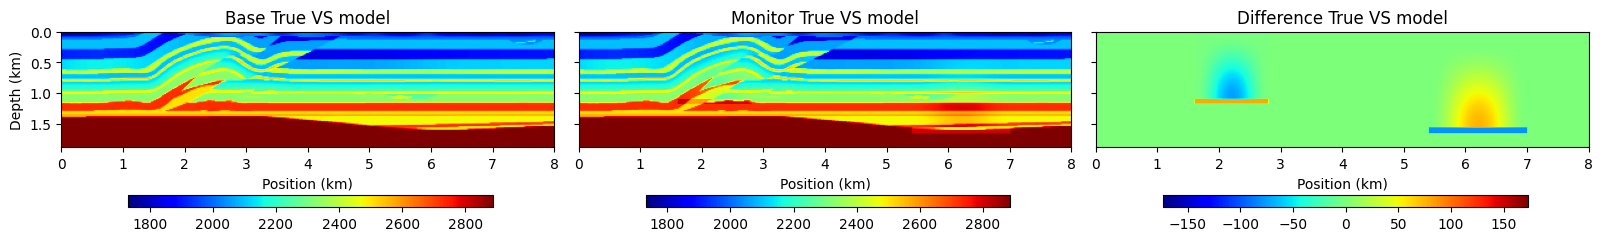

In [8]:
plot_base_monitor(base_true_vs.detach().cpu().numpy(), monitor_true_vs.cpu().numpy(), np.array(dx)/1000, parameter='True VS', diff=300/np.sqrt(3))

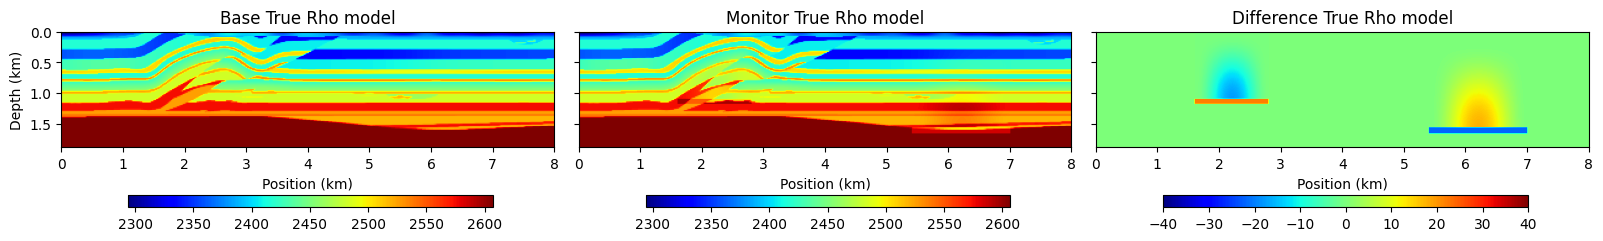

In [9]:
plot_base_monitor(base_true_rho.detach().cpu().numpy(), monitor_true_rho.cpu().numpy(), np.array(dx)/1000, parameter='True Rho', diff=40)

In [10]:
# Set sources and array configuration
# x_s
x_s = torch.zeros(num_shots, num_sources_per_shot, 2,
                               dtype=torch.long, device=device)
x_s[..., 1] = source_depth
x_s[:, 0, 0] = (torch.arange(1, num_shots+1) * source_spacing)

# x_r
x_r = torch.zeros(num_shots, num_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
x_r[..., 1] = receiver_depth
x_r[:, :, 0] = (
    (torch.arange(num_receivers_per_shot) * receiver_spacing).repeat(num_shots, 1)
)

/tmp/ipykernel_19712/1054860786.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


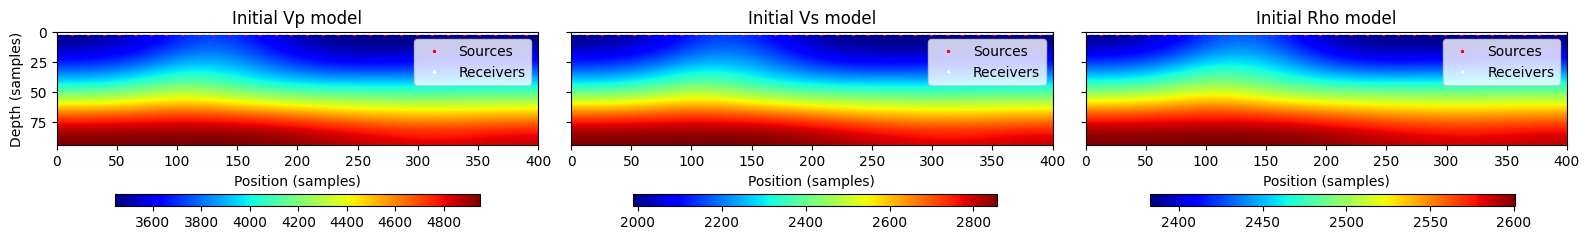

In [11]:
box_min = monitor_true_vp.cpu().numpy().min()
box_max = monitor_true_vp.cpu().numpy().max()

# Do a 1x3 plot showing true base, monitor and difference models
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
# Plot true model
vmin=model_init_vp.detach().cpu().numpy().min()
vmax=model_init_vp.detach().cpu().numpy().max()
im = axs[0].imshow(model_init_vp.detach().cpu().numpy(), vmin=vmin, vmax=vmax, cmap='jet', \
              extent=[0, model_init_vp.shape[1], model_init_vp.shape[0], 0])
axs[0].set_title('Initial Vp model')
axs[0].set_xlabel('Position (samples)')
axs[0].set_ylabel('Depth (samples)')

pos = axs[0].get_position()
cbar_ax = fig.add_axes([pos.x0 - 0.05, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Plot monitor model
vmin=model_init_vs.detach().cpu().numpy().min()
vmax=model_init_vs.detach().cpu().numpy().max()
im = axs[1].imshow(model_init_vs.cpu().numpy(), vmin=vmin, vmax=vmax, cmap='jet', \
                   extent=[0, model_init_vs.shape[1], model_init_vs.shape[0], 0])
axs[1].set_title('Initial Vs model')
axs[1].set_xlabel('Position (samples)')

pos = axs[1].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# Plot difference model
vmin=model_init_rho.detach().cpu().numpy().min()
vmax=model_init_rho.detach().cpu().numpy().max()
im = axs[2].imshow((model_init_rho.cpu()).numpy(), vmin=vmin, vmax=vmax, cmap='jet', \
                   extent=[0, model_init_rho.shape[1], model_init_rho.shape[0], 0])
axs[2].set_title('Initial Rho model')
axs[2].set_xlabel('Position (samples)')

pos = axs[2].get_position()
cbar_ax = fig.add_axes([pos.x0 + 0.05, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# Plot sources (red stars)
src_x = x_s[:, 0, 0].cpu().numpy()
src_z = x_s[:, 0, 1].cpu().numpy()
axs[0].plot(src_x, src_z, 'r*', markersize=2, label='Sources')
axs[1].plot(src_x, src_z, 'r*', markersize=2, label='Sources')
axs[2].plot(src_x, src_z, 'r*', markersize=2, label='Sources')
# Plot receivers (white triangles)
rec_x = x_r[0, :, 0].cpu().numpy()
rec_z = x_r[0, :, 1].cpu().numpy()
axs[0].plot(rec_x, rec_z, 'w^', markersize=2, label='Receivers')
axs[1].plot(rec_x, rec_z, 'w^', markersize=2, label='Receivers')
axs[2].plot(rec_x, rec_z, 'w^', markersize=2, label='Receivers')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
plt.tight_layout();

In [12]:
# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(peak_freq, nt, dt, peak_source_time)
    .repeat(num_shots, num_sources_per_shot, 1)
    .to(device)
)

source = source_amplitudes

# Create observed data using true models
receiver_amplitudes_true = elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(base_true_vp.T, base_true_vs.T,
                                               base_true_rho.T),
    dx, dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=x_s,
    receiver_locations_y=x_r,
    accuracy=4,
    pml_width=pml_width,
    pml_freq=peak_freq)[-2]

receiver_amplitudes_true = highpass_filter(2.5, receiver_amplitudes_true.cpu(), dt=dt, pad=[10, 10, 0, 0, 0, 0]).to(device)
rcv_amps_true = receiver_amplitudes_true.clone()
rcv_amps_true.shape

torch.Size([30, 400, 2000])

In [13]:
rcv_amps_true = add_awgn(receiver_amplitudes_true, snr_db=5)

In [14]:
# Compute snr
snr = 10 * torch.log10(
    torch.mean(receiver_amplitudes_true ** 2) /
    torch.mean((receiver_amplitudes_true - rcv_amps_true) ** 2)
).item()
print(f'SNR: {snr:.2f} dB')

SNR: 5.00 dB


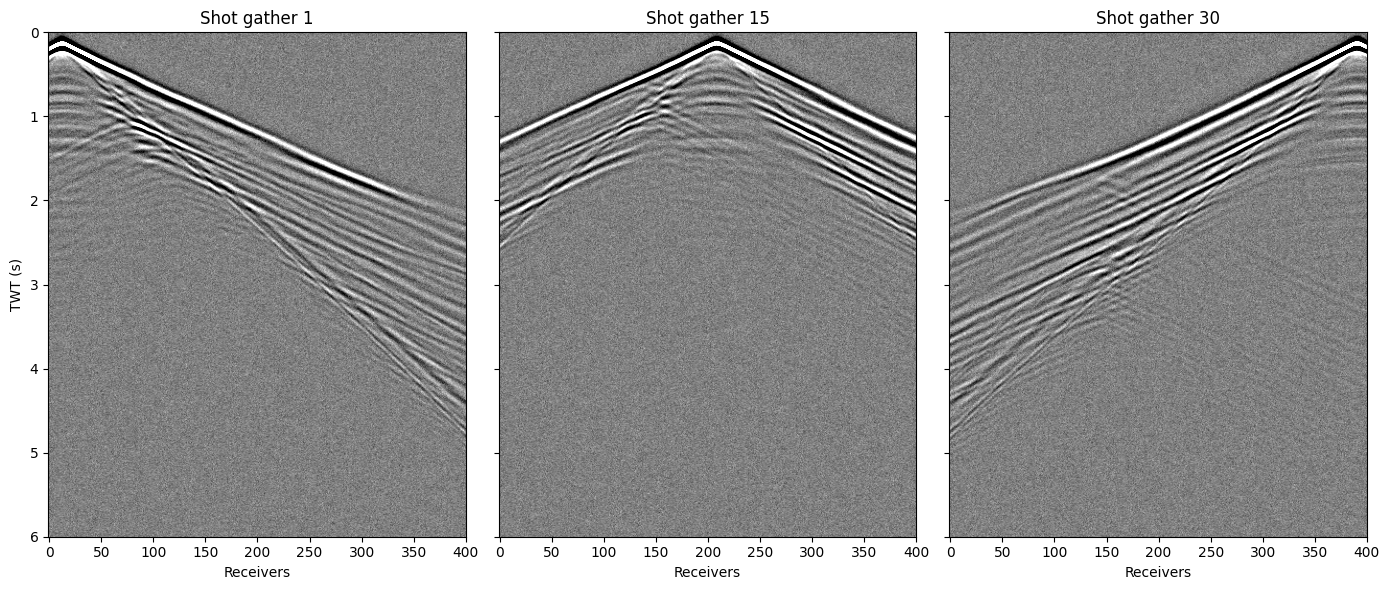

In [15]:
# Plot three shot gathers (beginning, middle and end of num_shots)
fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
vmax = 0.05*receiver_amplitudes_true.max()
vmin = -vmax
# Plot first shot gather
im = axs[0].imshow(rcv_amps_true[0, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[0].set_title('Shot gather 1')
axs[0].set_xlabel('Receivers')
axs[0].set_ylabel('TWT (s)')
# Plot middle shot gather
im = axs[1].imshow(rcv_amps_true[num_shots // 2, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[1].set_title(f'Shot gather {num_shots // 2}')
axs[1].set_xlabel('Receivers')
# Plot last shot gather
im = axs[2].imshow(rcv_amps_true[-1, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[2].set_title(f'Shot gather {num_shots}')
axs[2].set_xlabel('Receivers')
plt.tight_layout();

In [16]:
# Learning rates
fwi_lrp            = 30       # learning rate for updating the model.
fwi_lrs            = 10        # learning rate for updating the model.
fwi_lrrho          = 2       # learning rate for updating the model.

fwi_batch         =  num_shots      # number of batches for FWI.
fwi_num_epochs    = 166      # number of FWI iteration.
sim_lr            = 1*1e-5   # learning rate for Soamese network.
savepoch = 15                 # Saving models each 50 FWI iterations

In [17]:
#Learning Schedule
def lr_lambda(epoch):
    return 1/2

### optimizer for the velocity model
optimizerp = optim.Adam([{'params': model_vp, 'lr':fwi_lrp, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
optimizers = optim.Adam([{'params': model_vs, 'lr':fwi_lrs, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
# optimizerrho = optim.Adam([{'params': model_rho, 'lr':fwi_lrrho, 'betas':(0.5, 0.99), 'eps':1e-8,
#                           'weight_decay':0}])


schedulerp = torch.optim.lr_scheduler.MultiplicativeLR(optimizerp, lr_lambda=lr_lambda)
schedulers = torch.optim.lr_scheduler.MultiplicativeLR(optimizers, lr_lambda=lr_lambda)
# schedulerrho = torch.optim.lr_scheduler.MultiplicativeLR(optimizerrho, lr_lambda=lr_lambda)


############## Init  ################# 
SNRP = 0.0
SSIMP = 0.0
ERRORP = 0.0

SNRS = 0.0
SSIMS = 0.0
ERRORS = 0.0

SNRrho = 0.0
SSIMrho = 0.0
ERRORrho = 0.0

Loss = 0.0

In [18]:
import torch.nn.functional as F
# Starting the FWI loop.
# global model_vp, model_vs, model_rho, source_amplitudes_init, SNRP, SSIMP, Loss, ERRORS, SNRS, SSIMS, ERRORS, SNRrho, SSIMrho, ERRORrho

# Scaling factor
ma = 1/rcv_amps_true.max().detach().cpu().numpy()
con = 10*ma

t_start = time.time()
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
# fwi_num_epochs=15
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizerps to zero grad.
        optimizerp.zero_grad()
        optimizers.zero_grad()
        # optimizerrho.zero_grad()

        # Forward modeling based on AWE (DeepWave).
        batch_src_amps = source[it::fwi_batch].to(device)
        batch_rcv_amps_true = rcv_amps_true[it::fwi_batch,:,:].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        #batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred = elastic( *deepwave.common.vpvsrho_to_lambmubuoyancy(model_vp.T, model_vs.T,
                                        model_rho.T),
                                        dx, dt,
                                        source_amplitudes_y=batch_src_amps,
                                        source_locations_y=batch_x_s,
                                        receiver_locations_y=batch_x_r,
                                        accuracy=4,
                                        pml_width=pml_width,
                                        pml_freq=peak_freq)[-2]

        batch_rcv_amps_true = con*batch_rcv_amps_true[0,:,:]
        
        batch_rcv_amps_pred = con*batch_rcv_amps_pred[0,:,:]

        loss = F.mse_loss(batch_rcv_amps_pred, batch_rcv_amps_true)
        # observed_l2_norm = torch.norm(batch_rcv_amps_true, p=2)
        # loss = loss1/observed_l2_norm
        
        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp,1e3) 
        torch.nn.utils.clip_grad_value_(model_vs,1e3) 
        # torch.nn.utils.clip_grad_value_(model_rho,1e3) 

        # Update the velocity model
        optimizerp.step()
        optimizers.step()
        # optimizerrho.step()
        # clip the model value that keep the minimum value is larger than 0
        model_vp.data=torch.clamp(model_vp.data,min=1e-12)
        model_vs.data=torch.clamp(model_vs.data,min=1e-12)
        # model_rho.data=torch.clamp(model_rho.data,min=1e-12)
        
        # Compute density model with Garner's relation
        model_rho = vp_to_rho(model_vp)*1000  # Convert to kg/m^3

    # Update the learning rate each 100 FWI iterations .
    if i>0 and i%100==0:
        schedulerp.step()
        schedulers.step()
        # schedulerrho.step()
    after_lr1 = optimizerp.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    #P model
    snrP = ComputeSNR(model_vp.detach().cpu().numpy(),  
              base_true_vp.detach().cpu().numpy())
    SNRP = np.append(SNRP, snrP)

    ssimP = ComputeSSIM(model_vp.detach().cpu().numpy(), \
              base_true_vp.detach().cpu().numpy())
    SSIMP = np.append(SSIMP, ssimP)

    rerrorP = ComputeRE(model_vp.detach().cpu().numpy(), \
              base_true_vp.detach().cpu().numpy())
    ERRORP = np.append(ERRORP, rerrorP)
    
    # S Model
    snrS = ComputeSNR(model_vs.detach().cpu().numpy(),  
              base_true_vs.detach().cpu().numpy())
    SNRS = np.append(SNRS, snrS)

    ssimS = ComputeSSIM(model_vs.detach().cpu().numpy(), \
              base_true_vs.detach().cpu().numpy())
    SSIMS = np.append(SSIMS, ssimS)

    rerrorS = ComputeRE(model_vs.detach().cpu().numpy(), \
              base_true_vs.detach().cpu().numpy())
    ERRORS = np.append(ERRORS, rerrorS)
    
    # Rho model
    snrrho = ComputeSNR(model_rho.detach().cpu().numpy(),  
              base_true_rho.detach().cpu().numpy())
    SNRrho = np.append(SNRrho, snrrho)

    ssimrho = ComputeSSIM(model_rho.detach().cpu().numpy(), \
              base_true_rho.detach().cpu().numpy())
    SSIMrho = np.append(SSIMrho, ssimrho)

    rerrorrho = ComputeRE(model_rho.detach().cpu().numpy(), \
              base_true_rho.detach().cpu().numpy())
    ERRORrho = np.append(ERRORrho, rerrorrho)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch,  'lr_vel:' , str(after_lr1), 'SNR_P:', snrP, 'SSIM_P:', ssimP.cpu().detach().cpu().numpy(), \
          'SNR_S:', snrS, 'SSIM_S:', ssimS.cpu().detach().cpu().numpy(), 'SNR_rho:', snrrho, 'SSIM_rho:', ssimrho.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        print('Saving the model and metrics...')
        spio.savemat(fwi_result+'BaseVP_denFWI.mat', \
                         {'rec':model_vp.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'BaseVS_denFWI.mat', \
                         {'rec':model_vs.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'BaseRho_denFWI.mat', \
                         {'rec':model_rho.cpu().data.numpy()}) 
        
        spio.savemat(fwi_result+'BaseMetric_denFWI.mat', \
                         {'SNRP':SNRP,'SSIMP':SSIMP, \
                          'Loss':Loss,'ERRORP':ERRORP,
                         'SNRS':SNRS,'SSIMS':SSIMS, 'ERRORS':ERRORS, 'SNRrho':SNRrho,'SSIMrho':SSIMrho,'ERRORrho':ERRORrho}) 
  
# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result_base_denFWI.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snrP,ssimP,rerrorP)), fmt='%5.4f') 

Epoch: 1 Loss:  0.02358631125340859 lr_vel: 30 SNR_P: 25.690427281058753 SSIM_P: 0.25941297 SNR_S: 25.744123683524705 SSIM_S: 0.36186096 SNR_rho: 37.589704615053456 SSIM_rho: 0.45565715
Epoch: 2 Loss:  0.01847764998674393 lr_vel: 30 SNR_P: 26.014023538314927 SSIM_P: 0.30485034 SNR_S: 26.097464292410194 SSIM_S: 0.42121536 SNR_rho: 37.972974754549725 SSIM_rho: 0.49014077
Epoch: 3 Loss:  0.017325647299488385 lr_vel: 30 SNR_P: 26.238246216214552 SSIM_P: 0.33253428 SNR_S: 26.38792662623797 SSIM_S: 0.4616937 SNR_rho: 38.255054601327146 SSIM_rho: 0.51214945
Epoch: 4 Loss:  0.016905795534451803 lr_vel: 30 SNR_P: 26.406984659320763 SSIM_P: 0.35264784 SNR_S: 26.64557184684756 SSIM_S: 0.49142942 SNR_rho: 38.464337255094236 SSIM_rho: 0.52843416
Epoch: 5 Loss:  0.016688432171940805 lr_vel: 30 SNR_P: 26.542717633190538 SSIM_P: 0.3681433 SNR_S: 26.879115176200163 SSIM_S: 0.5158432 SNR_rho: 38.63008008100293 SSIM_rho: 0.54085344
Epoch: 6 Loss:  0.016555539704859255 lr_vel: 30 SNR_P: 26.656842376117016

Final results Vp: 	 Final results Vs: 	 Final results rho:
Loss = 0.015995648130774497
SNR = 29.716975026422155) 	 SNR = 32.18607863153454 	 SNR = 41.593865853216954
SSIM = 0.6213870048522949) 	 SSIM = 0.7827681303024292 	 SSIM = 0.7609663009643555
RE = 0.03267015904230395) 	 RE = 0.02458646371579791 	 RE = 0.008323513865711007)


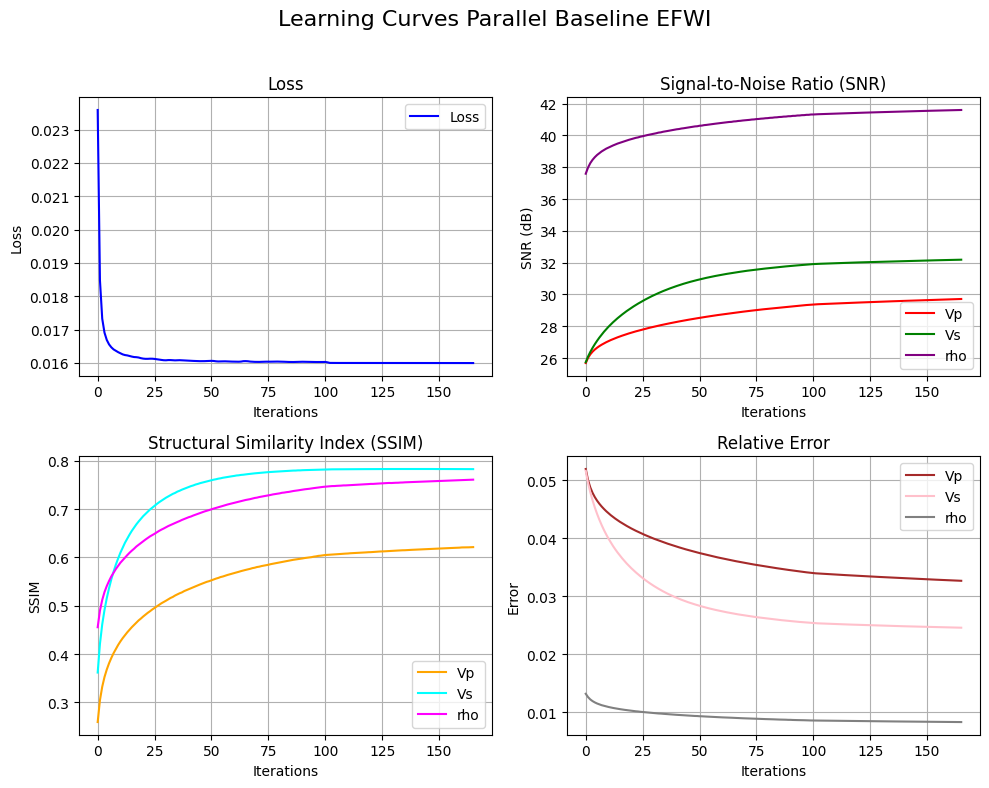

In [9]:
plot_metrics_efwi(fwi_result, 'BaseMetric_denFWI.mat', title='Parallel Baseline EFWI')

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/ElasticSiameseFWI-pub/utils/utils.py:877: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


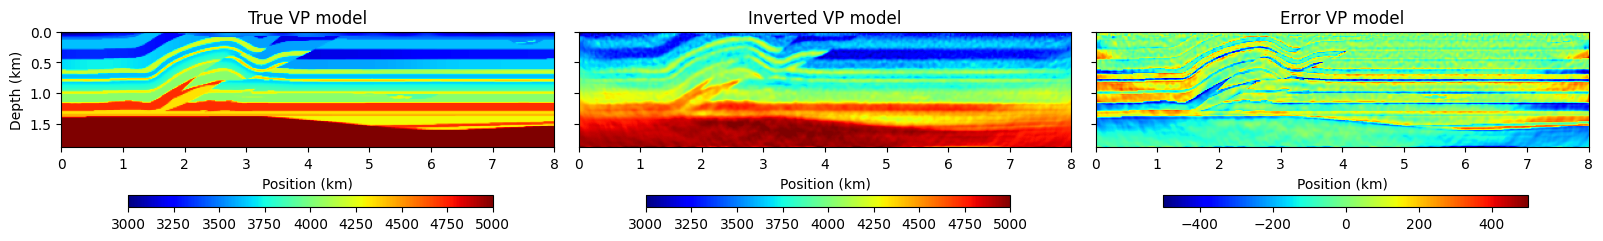

In [19]:
base_inv_vp = scipy.io.loadmat(fwi_result + 'BaseVP_denFWI.mat')
base_inv_vp = base_inv_vp['rec']
# base_inv_vp = model_vp.detach().cpu().numpy()

base_true_vp = base_true_vp.detach().cpu()
plot_true_inv(base_true_vp.numpy(), base_inv_vp, np.array(dx)/1000, parameter='VP', diff=500)

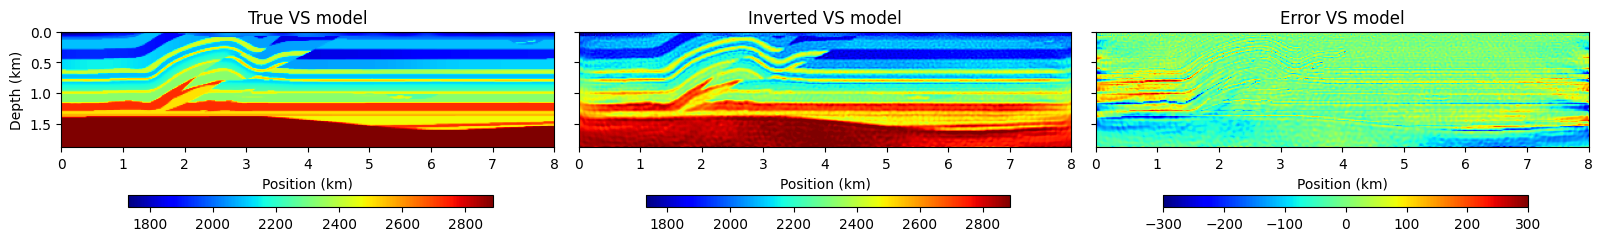

In [20]:
base_inv_vs = scipy.io.loadmat(fwi_result + 'BaseVS_denFWI.mat')
base_inv_vs = base_inv_vs['rec']
# base_inv_vs = model_vs.detach().cpu().numpy()

base_true_vs = base_true_vs.detach().cpu()
plot_true_inv(base_true_vs.numpy(), base_inv_vs, np.array(dx)/1000, parameter='VS', diff=300)

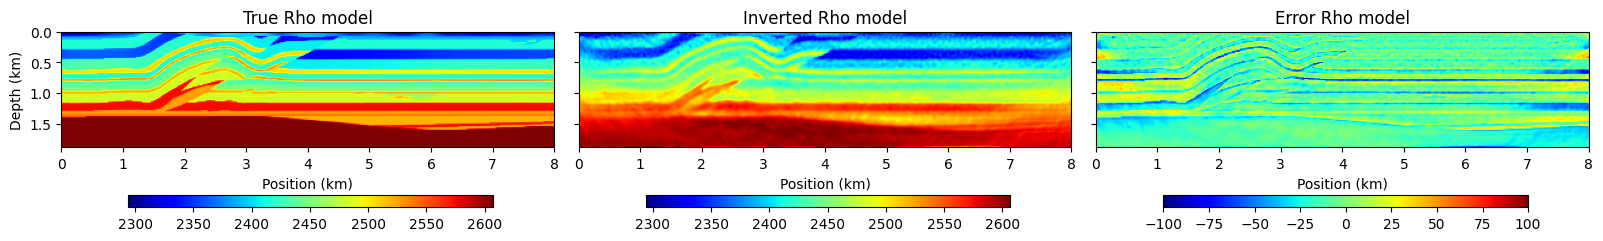

In [21]:
base_inv_rho = scipy.io.loadmat(fwi_result + 'BaseRho_denFWI.mat')
base_inv_rho = base_inv_rho['rec']
# base_inv_rho = model_rho.detach().cpu().numpy()

base_true_rho = base_true_rho.detach().cpu()
plot_true_inv(base_true_rho.numpy(), base_inv_rho, np.array(dx)/1000, parameter='Rho', diff=100)

## Monitor parallel inversion

In [22]:
# Convert models to tensors but keep them on CPU for now
monitor_true_vp = monitor_true_vp.to(device)
monitor_true_rho = monitor_true_rho.to(device)
monitor_true_vs = monitor_true_vs.to(device)

# Create observed data using true models
receiver_amplitudes_true = elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(monitor_true_vp.T, monitor_true_vs.T,
                                               monitor_true_rho.T),
    dx, dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=x_s,
    receiver_locations_y=x_r,
    accuracy=4,
    pml_width=pml_width,
    pml_freq=peak_freq)[-2]

receiver_amplitudes_true = highpass_filter(2.5, receiver_amplitudes_true.cpu(), dt=dt, pad=[10, 10, 0, 0, 0, 0]).to(device)
rcv_amps_true = receiver_amplitudes_true.clone()
rcv_amps_true.shape

torch.Size([30, 400, 2000])

In [23]:
# Add noise
rcv_amps_true = add_awgn(rcv_amps_true, snr_db=5)
# Compute snr
snr = 10 * torch.log10(
    torch.mean(receiver_amplitudes_true ** 2) /
    torch.mean((receiver_amplitudes_true - rcv_amps_true) ** 2)
).item()
print(f'SNR: {snr:.2f} dB')

SNR: 5.00 dB


In [24]:
# Reinitialize starting models
model_vp = model_init_vp.clone().to(device)
model_vp = torch.nn.Parameter(model_vp)

model_vs = model_init_vs.clone().to(device)
model_vs = torch.nn.Parameter(model_vs)

model_rho = model_init_rho.clone().to(device)
model_rho.requires_grad_(False);
# model_rho = torch.nn.Parameter(model_rho)

In [25]:
#Learning Schedule
def lr_lambda(epoch):
    return 1/2

### optimizer for the velocity model
optimizerp = optim.Adam([{'params': model_vp, 'lr':fwi_lrp, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
optimizers = optim.Adam([{'params': model_vs, 'lr':fwi_lrs, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
# optimizerrho = optim.Adam([{'params': model_rho, 'lr':fwi_lrrho, 'betas':(0.5, 0.99), 'eps':1e-8,
#                           'weight_decay':0}])
#Best

schedulerp = torch.optim.lr_scheduler.MultiplicativeLR(optimizerp, lr_lambda=lr_lambda)
schedulers = torch.optim.lr_scheduler.MultiplicativeLR(optimizers, lr_lambda=lr_lambda)
# schedulerrho = torch.optim.lr_scheduler.MultiplicativeLR(optimizerrho, lr_lambda=lr_lambda)

############## Init  ################# 
SNRP = 0.0
SSIMP = 0.0
ERRORP = 0.0

SNRS = 0.0
SSIMS = 0.0
ERRORS = 0.0

SNRrho = 0.0
SSIMrho = 0.0
ERRORrho = 0.0

Loss = 0.0

In [26]:
# Convert base_inv_vp and vs to tensor
base_inv_vp = torch.from_numpy(base_inv_vp).float().to(device)
base_inv_vs = torch.from_numpy(base_inv_vs).float().to(device)

In [27]:
import torch.nn.functional as F

# Scaling factor
ma = 1/rcv_amps_true.max().detach().cpu().numpy()
con = 10*ma

t_start = time.time()
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 

for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizerps to zero grad.
        optimizerp.zero_grad()
        optimizers.zero_grad()
        # optimizerrho.zero_grad()
                       
        # Forward modeling based on AWE (DeepWave).
        batch_src_amps = source[it::fwi_batch].to(device)
        batch_rcv_amps_true = rcv_amps_true[it::fwi_batch,:,:].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        #batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred = elastic( *deepwave.common.vpvsrho_to_lambmubuoyancy(model_vp.T, model_vs.T,
                                        model_rho.T),
                                        dx, dt,
                                        source_amplitudes_y=batch_src_amps,
                                        source_locations_y=batch_x_s,
                                        receiver_locations_y=batch_x_r,
                                        accuracy=4,
                                        pml_width=pml_width,
                                        pml_freq=peak_freq)[-2]

        batch_rcv_amps_true = con*batch_rcv_amps_true[0,:,:]

        batch_rcv_amps_pred = con*batch_rcv_amps_pred[0,:,:]

        loss = F.mse_loss(batch_rcv_amps_pred, batch_rcv_amps_true)
        # observed_l2_norm = torch.norm(batch_rcv_amps_true, p=2)
        # loss = loss1/observed_l2_norm

        reg_loss = 2.4e-11*(0.3*TVLoss(model_vp - base_inv_vp) + \
                            TVLoss(model_vs - base_inv_vs) )
        loss = loss + reg_loss
        
        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.

        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp,1e3) 
        torch.nn.utils.clip_grad_value_(model_vs,1e3) 
        # torch.nn.utils.clip_grad_value_(model_rho,1e3) 

        # Update the velocity model
        optimizerp.step()
        optimizers.step()
        # optimizerrho.step()
        # clip the model value that keep the minimum value is larger than 0
        model_vp.data=torch.clamp(model_vp.data,min=1e-12)
        model_vs.data=torch.clamp(model_vs.data,min=1e-12)
        # model_rho.data=torch.clamp(model_rho.data,min=1e-12)

        model_rho = vp_to_rho(model_vp)*1000

    # Update the learning rate each 100 FWI iterations .
    if i>0 and i%100==0:
        schedulerp.step()
        schedulers.step()
        # schedulerrho.step()
    after_lr1 = optimizerp.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    #P model
    snrP = ComputeSNR(model_vp.detach().cpu().numpy(),  
              monitor_true_vp.detach().cpu().numpy())
    SNRP = np.append(SNRP, snrP)

    ssimP = ComputeSSIM(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    SSIMP = np.append(SSIMP, ssimP)

    rerrorP = ComputeRE(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    ERRORP = np.append(ERRORP, rerrorP)
    
    # S Model
    snrS = ComputeSNR(model_vs.detach().cpu().numpy(),  
              monitor_true_vs.detach().cpu().numpy())
    SNRS = np.append(SNRS, snrS)

    ssimS = ComputeSSIM(model_vs.detach().cpu().numpy(), \
              base_true_vs.detach().cpu().numpy())
    SSIMS = np.append(SSIMS, ssimS)

    rerrorS = ComputeRE(model_vs.detach().cpu().numpy(), \
              monitor_true_vs.detach().cpu().numpy())
    ERRORS = np.append(ERRORS, rerrorS)
    
    # Rho model
    snrrho = ComputeSNR(model_rho.detach().cpu().numpy(),  
              monitor_true_rho.detach().cpu().numpy())
    SNRrho = np.append(SNRrho, snrrho)

    ssimrho = ComputeSSIM(model_rho.detach().cpu().numpy(), \
              monitor_true_rho.detach().cpu().numpy())
    SSIMrho = np.append(SSIMrho, ssimrho)

    rerrorrho = ComputeRE(model_rho.detach().cpu().numpy(), \
              monitor_true_rho.detach().cpu().numpy())
    ERRORrho = np.append(ERRORrho, rerrorrho)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch,  'lr_vel:' , str(after_lr1), 'SNR_P:', snrP, 'SSIM_P:', ssimP.cpu().detach().cpu().numpy(), \
          'SNR_S:', snrS, 'SSIM_S:', ssimS.cpu().detach().cpu().numpy(), 'SNR_rho:', snrrho, 'SSIM_rho:', ssimrho.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'MonitorVP_denFWI.mat', \
                         {'rec':model_vp.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'MonitorVS_denFWI.mat', \
                         {'rec':model_vs.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'MonitorRho_denFWI.mat', \
                         {'rec':model_rho.cpu().data.numpy()}) 
        
        spio.savemat(fwi_result+'MonitorMetric_denFWI.mat', \
                         {'SNRP':SNRP,'SSIMP':SSIMP, \
                          'Loss':Loss,'ERRORP':ERRORP,
                         'SNRS':SNRS,'SSIMS':SSIMS, 'ERRORS':ERRORS, 'SNRrho':SNRrho,'SSIMrho':SSIMrho,'ERRORrho':ERRORrho}) 
  
# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result_monitor_denFWI.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snrP,ssimP,rerrorP)), fmt='%5.4f') 

Epoch: 1 Loss:  0.023939790576696394 lr_vel: 30 SNR_P: 25.71643926238433 SSIM_P: 0.26245305 SNR_S: 25.77568725490871 SSIM_S: 0.3641202 SNR_rho: 37.58831413118677 SSIM_rho: 0.4546404
Epoch: 2 Loss:  0.018716759172578652 lr_vel: 30 SNR_P: 26.05156628928347 SSIM_P: 0.30948752 SNR_S: 26.149857919529232 SSIM_S: 0.425888 SNR_rho: 37.97750752491141 SSIM_rho: 0.4900722
Epoch: 3 Loss:  0.01755412177493175 lr_vel: 30 SNR_P: 26.285409977547317 SSIM_P: 0.33843678 SNR_S: 26.463534631061645 SSIM_S: 0.46935922 SNR_rho: 38.26840921879865 SSIM_rho: 0.5139731
Epoch: 4 Loss:  0.017126709409058093 lr_vel: 30 SNR_P: 26.462836978644244 SSIM_P: 0.3594901 SNR_S: 26.745354585082296 SSIM_S: 0.5021287 SNR_rho: 38.48643363503651 SSIM_rho: 0.53148365
Epoch: 5 Loss:  0.016903075948357583 lr_vel: 30 SNR_P: 26.60691544276377 SSIM_P: 0.3761836 SNR_S: 27.002687243818706 SSIM_S: 0.5286758 SNR_rho: 38.66080872967187 SSIM_rho: 0.5451499
Epoch: 6 Loss:  0.016764971365531286 lr_vel: 30 SNR_P: 26.72913293866264 SSIM_P: 0.390

Final results Vp: 	 Final results Vs: 	 Final results rho:
Loss = 0.01616541047890981
SNR = 29.841524442189314) 	 SNR = 32.42487365984729 	 SNR = 41.679418608927236
SSIM = 0.6298278570175171) 	 SSIM = 0.7863757610321045 	 SSIM = 0.7655774354934692
RE = 0.03220503517893051) 	 RE = 0.02391973241636758 	 RE = 0.008241932806435807)


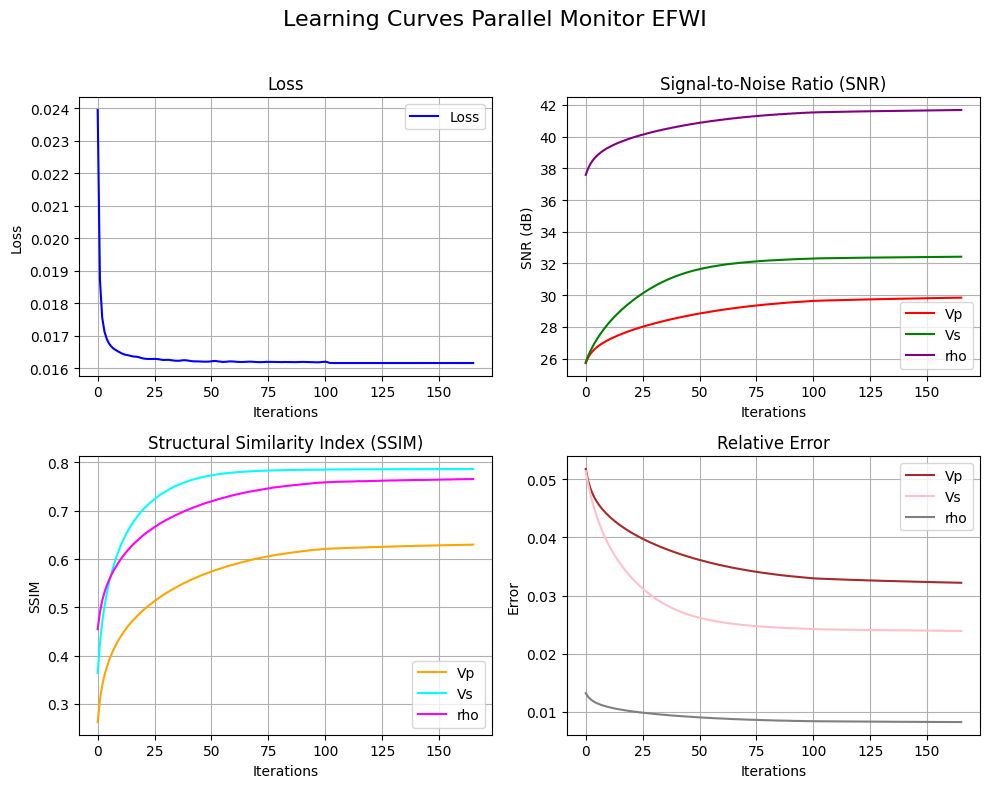

In [10]:
plot_metrics_efwi(fwi_result, 'MonitorMetric_denFWI.mat', title='Parallel Monitor EFWI')

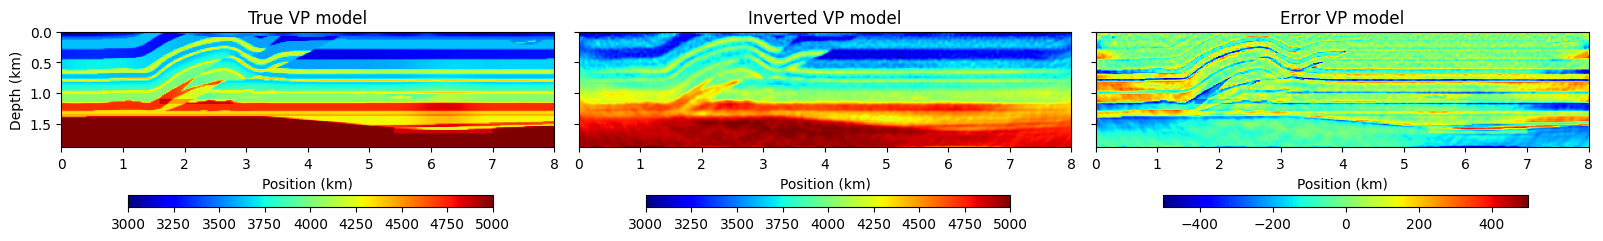

In [28]:
monitor_inv_vp = scipy.io.loadmat(fwi_result + 'MonitorVP_denFWI.mat')
monitor_inv_vp = monitor_inv_vp['rec']

monitor_true_vp = monitor_true_vp.detach().cpu()
plot_true_inv(monitor_true_vp.numpy(), monitor_inv_vp, np.array(dx)/1000, parameter='VP', diff=500)

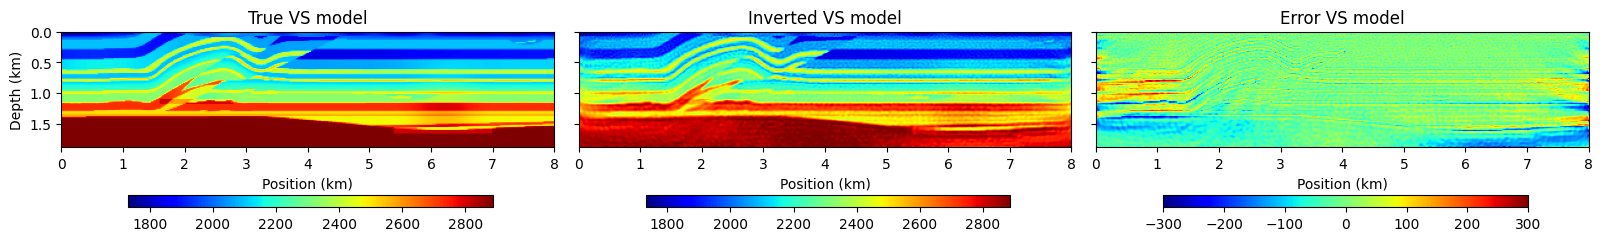

In [29]:
monitor_inv_vs = scipy.io.loadmat(fwi_result + 'MonitorVS_denFWI.mat')
monitor_inv_vs = monitor_inv_vs['rec']

monitor_true_vs = monitor_true_vs.detach().cpu()
plot_true_inv(monitor_true_vs.numpy(), monitor_inv_vs, np.array(dx)/1000, parameter='VS', diff=300)

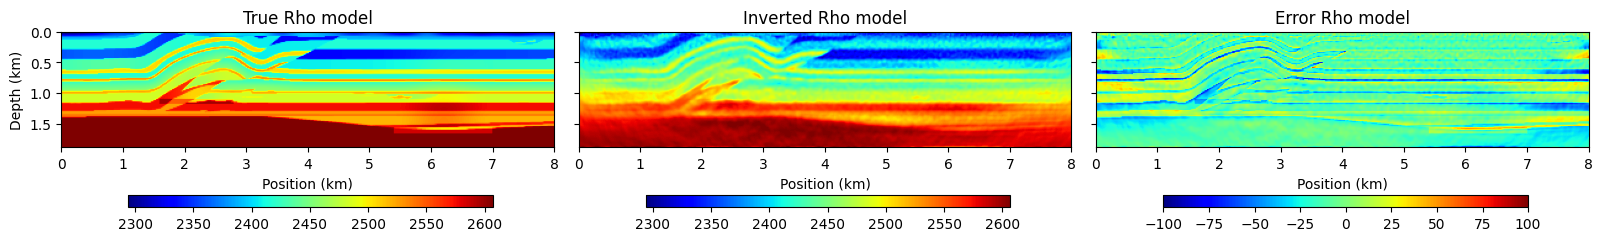

In [30]:
monitor_inv_rho = scipy.io.loadmat(fwi_result + 'MonitorRho_denFWI.mat')
monitor_inv_rho = monitor_inv_rho['rec']

monitor_true_rho = monitor_true_rho.detach().cpu()
plot_true_inv(monitor_true_rho.numpy(), monitor_inv_rho, np.array(dx)/1000, parameter='Rho', diff=100)

## Difference parallel approach

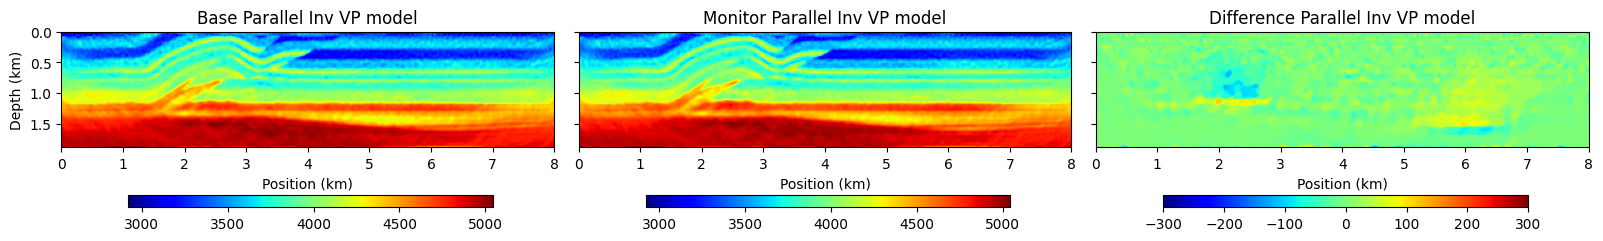

In [31]:
plot_base_monitor(base_inv_vp.cpu().numpy(), monitor_inv_vp, np.array(dx)/1000, parameter='Parallel Inv VP', diff=300)

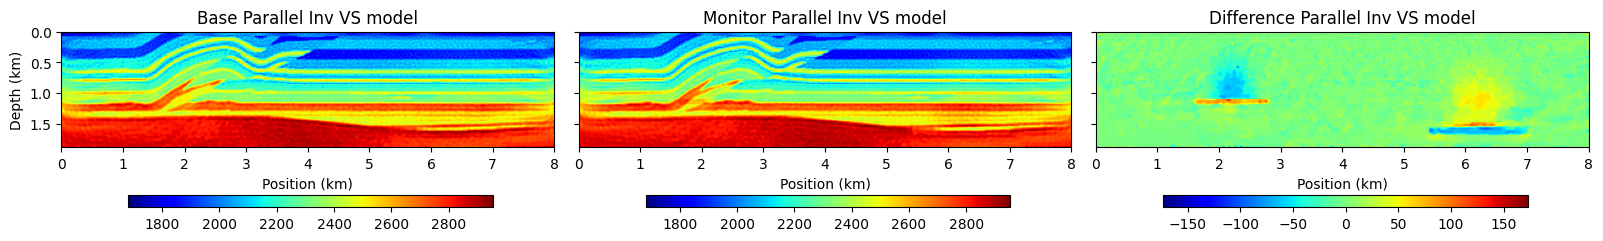

In [32]:
plot_base_monitor(base_inv_vs.cpu().numpy(), monitor_inv_vs, np.array(dx)/1000, parameter='Parallel Inv VS', diff=300/np.sqrt(3))

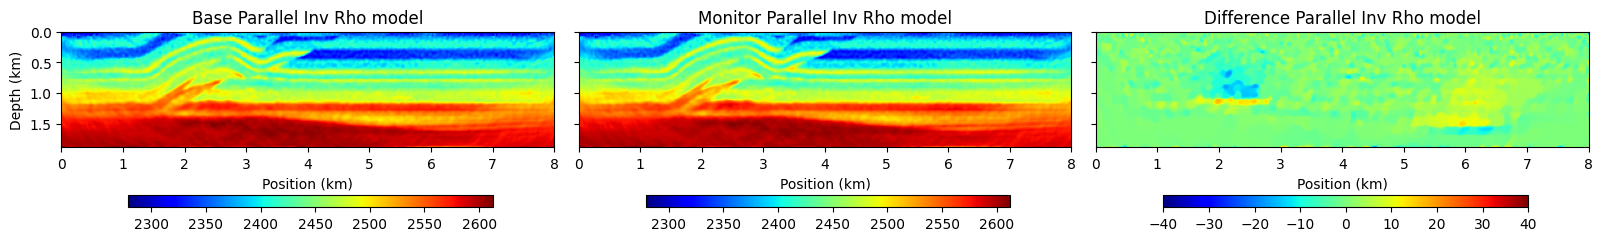

In [33]:
plot_base_monitor(base_inv_rho, monitor_inv_rho, np.array(dx)/1000, parameter='Parallel Inv Rho', diff=40)

/tmp/ipykernel_19712/26225618.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


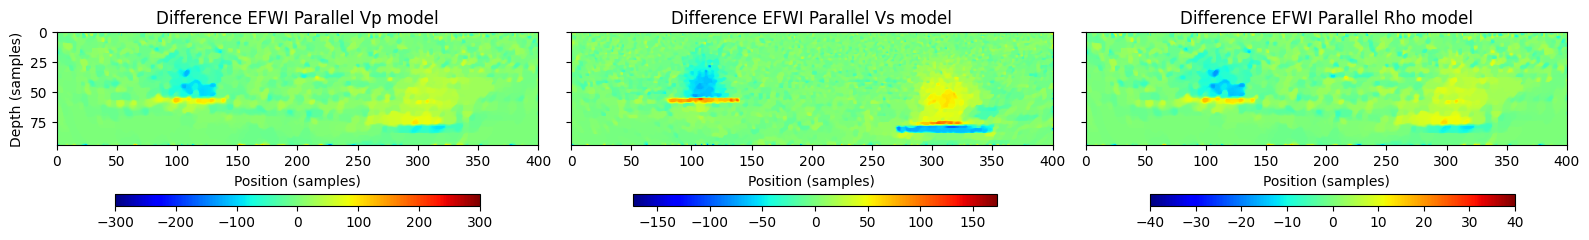

In [37]:
time_lapse_vp = monitor_inv_vp - base_inv_vp.cpu().numpy()
time_lapse_vs = monitor_inv_vs - base_inv_vs.cpu().numpy()
time_lapse_rho = monitor_inv_rho - base_inv_rho

# Do a 1x3 plot showing true base, monitor and difference models
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
# Plot true model
vmin=-300
vmax=300
im = axs[0].imshow(time_lapse_vp, vmin=vmin, vmax=vmax, cmap='jet', \
              extent=[0, monitor_inv_vp.shape[1], monitor_inv_vp.shape[0], 0])
axs[0].set_title('Difference EFWI Parallel Vp model')
axs[0].set_xlabel('Position (samples)')
axs[0].set_ylabel('Depth (samples)')

pos = axs[0].get_position()
cbar_ax = fig.add_axes([pos.x0 - 0.05, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Plot monitor model
vmin=-300/np.sqrt(3)
vmax=300/np.sqrt(3)
im = axs[1].imshow(time_lapse_vs, vmin=vmin, vmax=vmax, cmap='jet', \
                   extent=[0, monitor_inv_vp.shape[1], monitor_inv_vp.shape[0], 0])
axs[1].set_title('Difference EFWI Parallel Vs model')
axs[1].set_xlabel('Position (samples)')

pos = axs[1].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# Plot difference model
vmin=-40
vmax=40
im = axs[2].imshow(time_lapse_rho, vmin=vmin, vmax=vmax, cmap='jet', \
                   extent=[0, monitor_inv_vp.shape[1], monitor_inv_vp.shape[0], 0])
axs[2].set_title('Difference EFWI Parallel Rho model')
axs[2].set_xlabel('Position (samples)')

pos = axs[2].get_position()
cbar_ax = fig.add_axes([pos.x0 + 0.05, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

plt.tight_layout();

In [39]:
time_lapse_true_vp = monitor_true_vp.cpu().numpy() - base_true_vp.cpu().numpy()
time_lapse_parallel_vp = monitor_inv_vp - base_inv_vp.cpu().numpy()

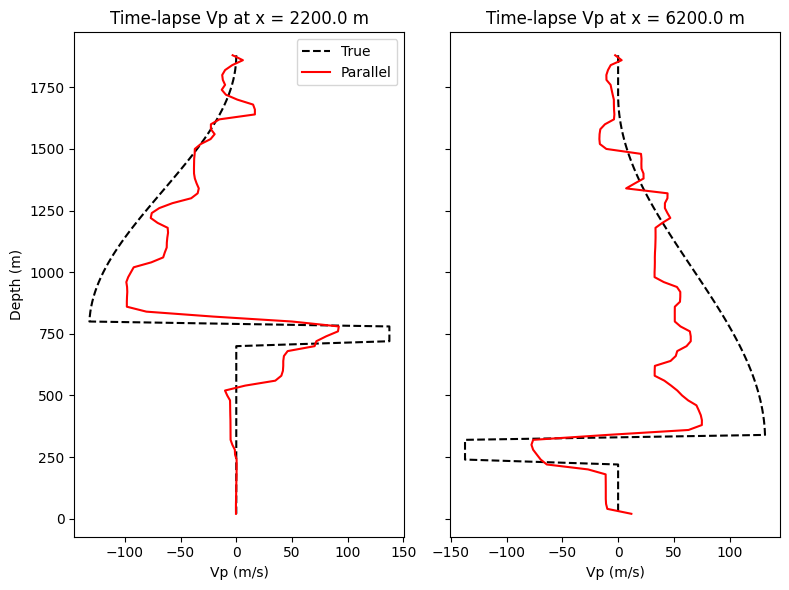

In [40]:
# Plot two vertical profiles comparing the three time_lapses
fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
vmax = 300
vmin = -vmax

z = np.arange(nz*dx[1], 0, -dx[1])

# Plot time_lapse_true at x = 55
axs[0].plot(time_lapse_true_vp[: , 110], z, 'k', ls='--', label='True')
axs[0].plot(time_lapse_parallel_vp[: , 110], z, 'r', label='Parallel')

axs[0].set_title(f'Time-lapse Vp at x = {110*dx[0]:.1f} m')
axs[0].set_xlabel('Vp (m/s)')
axs[0].set_ylabel('Depth (m)')

# Plot time_lapse_true at x = 105
axs[1].plot(time_lapse_true_vp[: , 310], z, 'k', ls='--', label='True')
axs[1].plot(time_lapse_parallel_vp[: , 310], z, 'r', label='Parallel')

axs[1].set_title(f'Time-lapse Vp at x = {310*dx[0]:.1f} m')
axs[1].set_xlabel('Vp (m/s)')

axs[0].legend()
plt.tight_layout();

In [43]:
time_lapse_true_vs = monitor_true_vs - base_true_vs.cpu().numpy()
time_lapse_parallel_vs = monitor_inv_vs - base_inv_vs.cpu().numpy()

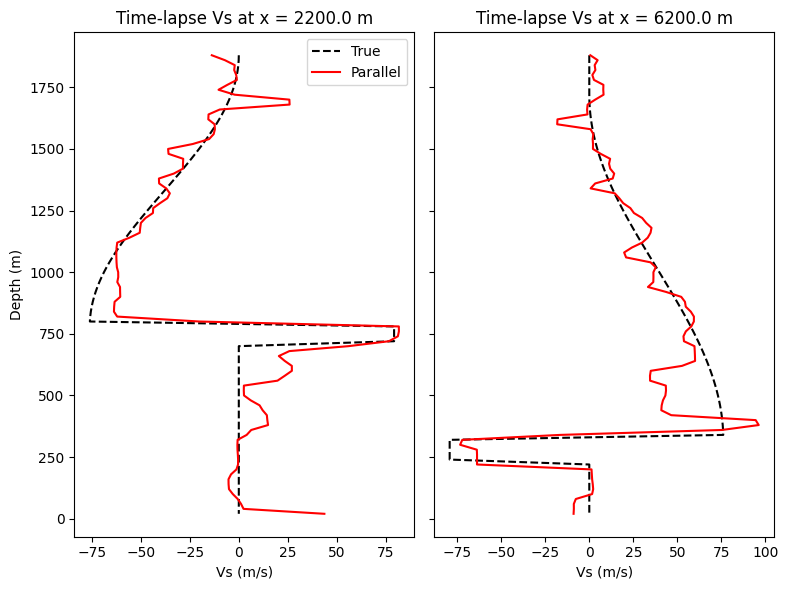

In [44]:
# Plot two vertical profiles comparing the three time_lapses
fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
vmax = 300
vmin = -vmax

z = np.arange(nz*dx[1], 0, -dx[1])

# Plot time_lapse_true at x = 55
axs[0].plot(time_lapse_true_vs[: , 110], z, 'k', ls='--', label='True')
axs[0].plot(time_lapse_parallel_vs[: , 110], z, 'r', label='Parallel')

axs[0].set_title(f'Time-lapse Vs at x = {110*dx[0]:.1f} m')
axs[0].set_xlabel('Vs (m/s)')
axs[0].set_ylabel('Depth (m)')

# Plot time_lapse_true at x = 105
axs[1].plot(time_lapse_true_vs[: , 310], z, 'k', ls='--', label='True')
axs[1].plot(time_lapse_parallel_vs[: , 310], z, 'r', label='Parallel')

axs[1].set_title(f'Time-lapse Vs at x = {310*dx[0]:.1f} m')
axs[1].set_xlabel('Vs (m/s)')

axs[0].legend()
plt.tight_layout();

In [45]:
time_lapse_true_rho = monitor_true_rho.cpu().numpy() - base_true_rho.cpu().numpy()
time_lapse_parallel_rho = monitor_inv_rho - base_inv_rho

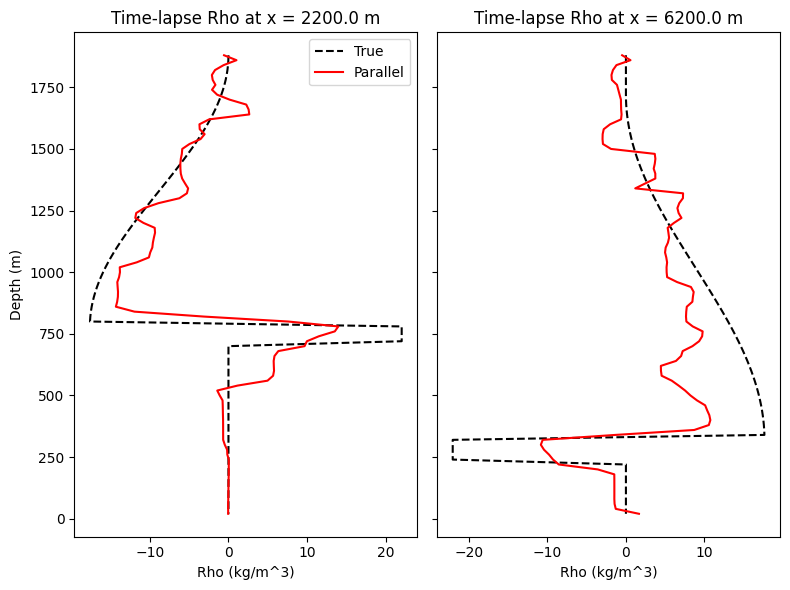

In [46]:
# Plot two vertical profiles comparing the three time_lapses
fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
vmax = 300
vmin = -vmax

z = np.arange(nz*dx[1], 0, -dx[1])

# Plot time_lapse_true at x = 55
axs[0].plot(time_lapse_true_rho[: , 110], z, 'k', ls='--', label='True')
axs[0].plot(time_lapse_parallel_rho[: , 110], z, 'r', label='Parallel')

axs[0].set_title(f'Time-lapse Rho at x = {110*dx[0]:.1f} m')
axs[0].set_xlabel('Rho (kg/m^3)')
axs[0].set_ylabel('Depth (m)')

# Plot time_lapse_true at x = 105
axs[1].plot(time_lapse_true_rho[: , 310], z, 'k', ls='--', label='True')
axs[1].plot(time_lapse_parallel_rho[: , 310], z, 'r', label='Parallel')

axs[1].set_title(f'Time-lapse Rho at x = {310*dx[0]:.1f} m')
axs[1].set_xlabel('Rho (kg/m^3)')

axs[0].legend()
plt.tight_layout();

## Monitor cascaded inversion

In [48]:
# Reinitialize starting models
model_vp = base_inv_vp.clone().to(device)
model_vp = torch.nn.Parameter(model_vp)

model_vs = base_inv_vs.clone().to(device)
model_vs = torch.nn.Parameter(model_vs)

model_rho = torch.from_numpy(base_inv_rho).clone().to(device)
model_rho.requires_grad_(False);
# model_rho = torch.nn.Parameter(model_rho)

In [49]:
#Learning Schedule
def lr_lambda(epoch):
    return 1/2

### optimizer for the velocity model
optimizerp = optim.Adam([{'params': model_vp, 'lr':fwi_lrp/2, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
optimizers = optim.Adam([{'params': model_vs, 'lr':fwi_lrs/2, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
# optimizerrho = optim.Adam([{'params': model_rho, 'lr':fwi_lrrho/2, 'betas':(0.5, 0.99), 'eps':1e-8,
#                           'weight_decay':0}])
#Best

schedulerp = torch.optim.lr_scheduler.MultiplicativeLR(optimizerp, lr_lambda=lr_lambda)
schedulers = torch.optim.lr_scheduler.MultiplicativeLR(optimizers, lr_lambda=lr_lambda)
# schedulerrho = torch.optim.lr_scheduler.MultiplicativeLR(optimizerrho, lr_lambda=lr_lambda)

############## Init  ################# 
SNRP = 0.0
SSIMP = 0.0
ERRORP = 0.0

SNRS = 0.0
SSIMS = 0.0
ERRORS = 0.0

SNRrho = 0.0
SSIMrho = 0.0
ERRORrho = 0.0

Loss = 0.0

In [50]:
# Scaling factor
ma = 1/rcv_amps_true.max().detach().cpu().numpy()
con = 10*ma

t_start = time.time()
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 

for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizerps to zero grad.
        optimizerp.zero_grad()
        optimizers.zero_grad()
        # optimizerrho.zero_grad()
        
        # Forward modeling based on AWE (DeepWave).
        batch_src_amps = source[it::fwi_batch].to(device)
        batch_rcv_amps_true = rcv_amps_true[it::fwi_batch,:,:].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        #batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred = elastic( *deepwave.common.vpvsrho_to_lambmubuoyancy(model_vp.T, model_vs.T,
                                        model_rho.T),
                                        dx, dt,
                                        source_amplitudes_y=batch_src_amps,
                                        source_locations_y=batch_x_s,
                                        receiver_locations_y=batch_x_r,
                                        accuracy=4,
                                        pml_width=pml_width,
                                        pml_freq=peak_freq)[-2]

        batch_rcv_amps_true = con*batch_rcv_amps_true[0,:,:]

        batch_rcv_amps_pred = con*batch_rcv_amps_pred[0,:,:]

        # normalized Loss Function
        loss = F.mse_loss(batch_rcv_amps_pred, batch_rcv_amps_true)
        # observed_l2_norm = torch.norm(batch_rcv_amps_true, p=2)
        # loss = loss1/observed_l2_norm
        
        epoch_loss += loss.item()
        loss.backward()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp,1e3) 
        torch.nn.utils.clip_grad_value_(model_vs,1e3) 
        # torch.nn.utils.clip_grad_value_(model_rho,1e3) 

        # Update the velocity model
        optimizerp.step()
        optimizers.step()
        # optimizerrho.step()
        # clip the model value that keep the minimum value is larger than 0
        model_vp.data=torch.clamp(model_vp.data,min=1e-12)
        model_vs.data=torch.clamp(model_vs.data,min=1e-12)
        # model_rho.data=torch.clamp(model_rho.data,min=1e-12)

        model_rho = vp_to_rho(model_vp)*1000

    # Update the learning rate each 100 FWI iterations .
    if i>0 and i%100==0:
        schedulerp.step()
        schedulers.step()
        # schedulerrho.step()
    after_lr1 = optimizerp.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    #P model
    snrP = ComputeSNR(model_vp.detach().cpu().numpy(),  
              monitor_true_vp.detach().cpu().numpy())
    SNRP = np.append(SNRP, snrP)

    ssimP = ComputeSSIM(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    SSIMP = np.append(SSIMP, ssimP)

    rerrorP = ComputeRE(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    ERRORP = np.append(ERRORP, rerrorP)
    
    # S Model
    snrS = ComputeSNR(model_vs.detach().cpu().numpy(),  
              monitor_true_vs.detach().cpu().numpy())
    SNRS = np.append(SNRS, snrS)

    ssimS = ComputeSSIM(model_vs.detach().cpu().numpy(), \
              base_true_vs.detach().cpu().numpy())
    SSIMS = np.append(SSIMS, ssimS)

    rerrorS = ComputeRE(model_vs.detach().cpu().numpy(), \
              monitor_true_vs.detach().cpu().numpy())
    ERRORS = np.append(ERRORS, rerrorS)
    
    # Rho model
    snrrho = ComputeSNR(model_rho.detach().cpu().numpy(),  
              monitor_true_rho.detach().cpu().numpy())
    SNRrho = np.append(SNRrho, snrrho)

    ssimrho = ComputeSSIM(model_rho.detach().cpu().numpy(), \
              monitor_true_rho.detach().cpu().numpy())
    SSIMrho = np.append(SSIMrho, ssimrho)

    rerrorrho = ComputeRE(model_rho.detach().cpu().numpy(), \
              monitor_true_rho.detach().cpu().numpy())
    ERRORrho = np.append(ERRORrho, rerrorrho)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch,  'lr_vel:' , str(after_lr1), 'SNR_P:', snrP, 'SSIM_P:', ssimP.cpu().detach().cpu().numpy(), \
          'SNR_S:', snrS, 'SSIM_S:', ssimS.cpu().detach().cpu().numpy(), 'SNR_rho:', snrrho, 'SSIM_rho:', ssimrho.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'MonitorCasVP_denFWI.mat', \
                         {'rec':model_vp.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'MonitorCasVS_denFWI.mat', \
                         {'rec':model_vs.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'MonitorCasRho_denFWI.mat', \
                         {'rec':model_rho.cpu().data.numpy()}) 
        
        spio.savemat(fwi_result+'MonitorCasMetric_denFWI.mat', \
                         {'SNRP':SNRP,'SSIMP':SSIMP, \
                          'Loss':Loss,'ERRORP':ERRORP,
                         'SNRS':SNRS,'SSIMS':SSIMS, 'ERRORS':ERRORS, 'SNRrho':SNRrho,'SSIMrho':SSIMrho,'ERRORrho':ERRORrho}) 
  
# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result_monitor_casdenFWI.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snrP,ssimP,rerrorP)), fmt='%5.4f') 

Epoch: 1 Loss:  0.016236898054679236 lr_vel: 15.0 SNR_P: 29.610634896867545 SSIM_P: 0.6142103 SNR_S: 32.117817983800755 SSIM_S: 0.78381485 SNR_rho: 41.43175862540731 SSIM_rho: 0.7523529
Epoch: 2 Loss:  0.01619509725521008 lr_vel: 15.0 SNR_P: 29.62600550670663 SSIM_P: 0.614984 SNR_S: 32.16070487105927 SSIM_S: 0.78437823 SNR_rho: 41.442296059463004 SSIM_rho: 0.75319624
Epoch: 3 Loss:  0.016182827887435754 lr_vel: 15.0 SNR_P: 29.639120234899945 SSIM_P: 0.61571395 SNR_S: 32.19061952754305 SSIM_S: 0.78482723 SNR_rho: 41.45743685964185 SSIM_rho: 0.7535477
Epoch: 4 Loss:  0.016176988556981086 lr_vel: 15.0 SNR_P: 29.65067666474522 SSIM_P: 0.61649054 SNR_S: 32.21451602112141 SSIM_S: 0.7852912 SNR_rho: 41.46883502363374 SSIM_rho: 0.7542688
Epoch: 5 Loss:  0.016173113572100797 lr_vel: 15.0 SNR_P: 29.66120621766466 SSIM_P: 0.6171324 SNR_S: 32.234413588771915 SSIM_S: 0.78564197 SNR_rho: 41.48125519602544 SSIM_rho: 0.7548503
Epoch: 6 Loss:  0.016171018841365972 lr_vel: 15.0 SNR_P: 29.67086274437818 

## Inversions cascaded approach

Final results Vp: 	 Final results Vs: 	 Final results rho:
Loss = 0.01614802461117506
SNR = 30.2497124147281) 	 SNR = 32.81288909446567 	 SNR = 41.996514127252944
SSIM = 0.6502367258071899) 	 SSIM = 0.7945190668106079 	 SSIM = 0.7825608849525452
RE = 0.030726590977220872) 	 RE = 0.022874707281280608 	 RE = 0.007946470832195438)


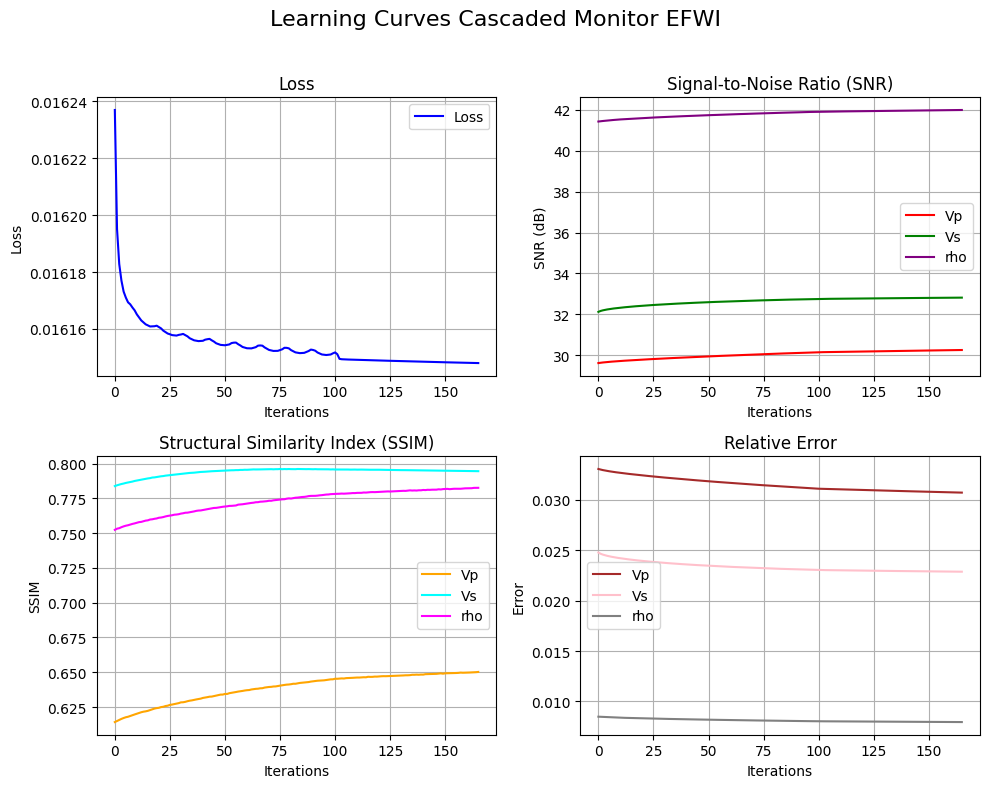

In [11]:
plot_metrics_efwi(fwi_result, 'MonitorCasMetric_denFWI.mat', title='Cascaded Monitor EFWI')

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/ElasticSiameseFWI-pub/utils/utils.py:877: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


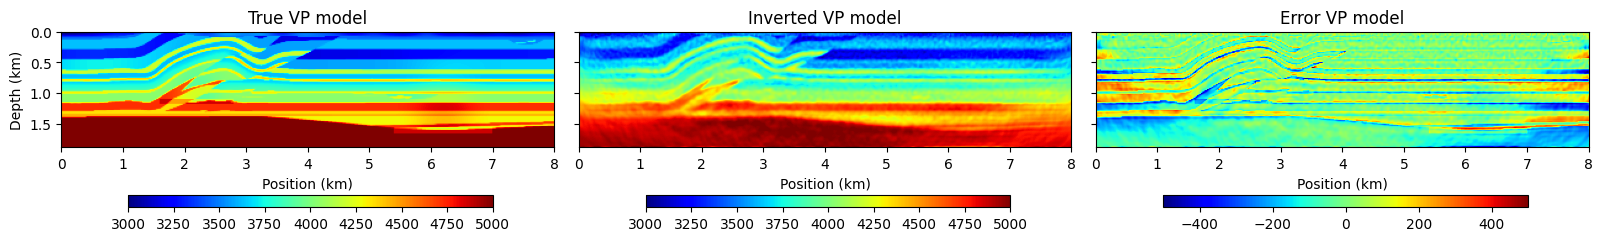

In [51]:
monitor_inv_vp = scipy.io.loadmat(fwi_result + 'MonitorCasVP_denFWI.mat')
monitor_inv_vp = monitor_inv_vp['rec']

monitor_true_vp = monitor_true_vp.detach().cpu()
plot_true_inv(monitor_true_vp.numpy(), monitor_inv_vp, np.array(dx)/1000, parameter='VP', diff=500)

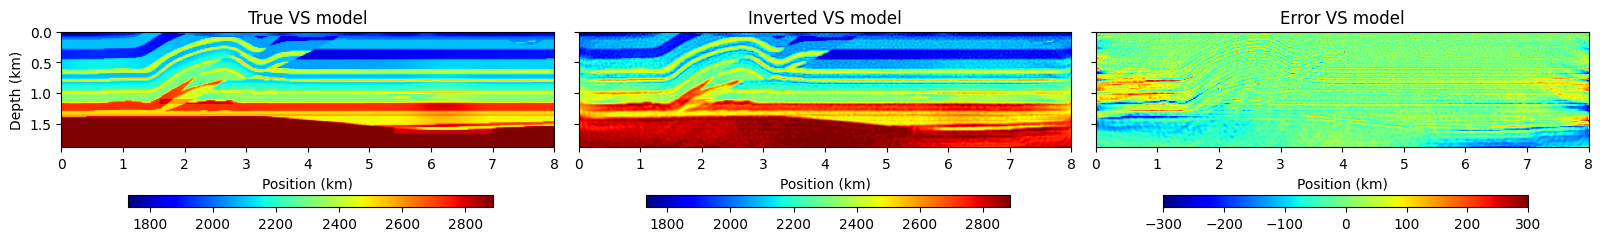

In [52]:
monitor_inv_vs = scipy.io.loadmat(fwi_result + 'MonitorCasVS_denFWI.mat')
monitor_inv_vs = monitor_inv_vs['rec']

monitor_true_vs = monitor_true_vs.detach().cpu()
plot_true_inv(monitor_true_vs.numpy(), monitor_inv_vs, np.array(dx)/1000, parameter='VS', diff=300)

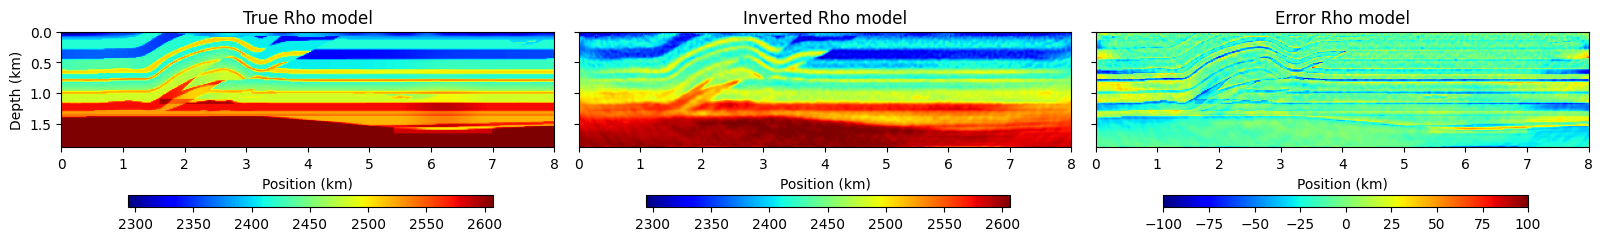

In [53]:
monitor_inv_rho = scipy.io.loadmat(fwi_result + 'MonitorCasRho_denFWI.mat')
monitor_inv_rho = monitor_inv_rho['rec']

monitor_true_rho = monitor_true_rho.detach().cpu()
plot_true_inv(monitor_true_rho.numpy(), monitor_inv_rho, np.array(dx)/1000, parameter='Rho', diff=100)

## Difference Cascaded approach

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/ElasticSiameseFWI-pub/utils/utils.py:839: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


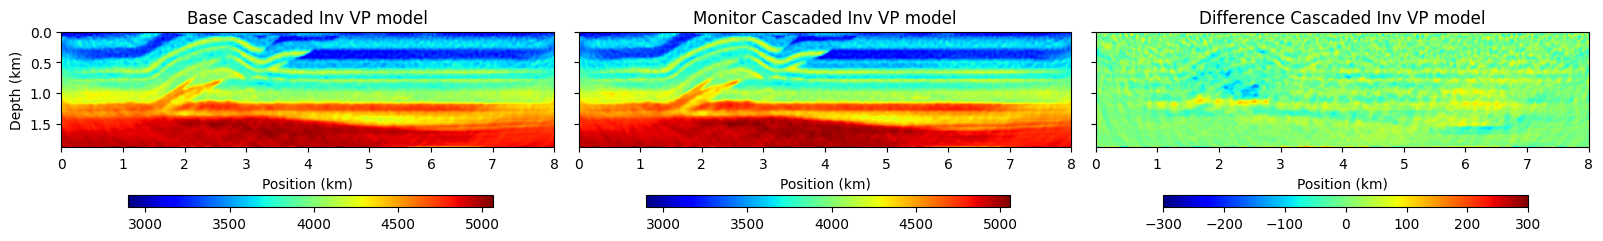

In [56]:
plot_base_monitor(base_inv_vp.cpu().numpy(), monitor_inv_vp, np.array(dx)/1000, parameter='Cascaded Inv VP', diff=300)

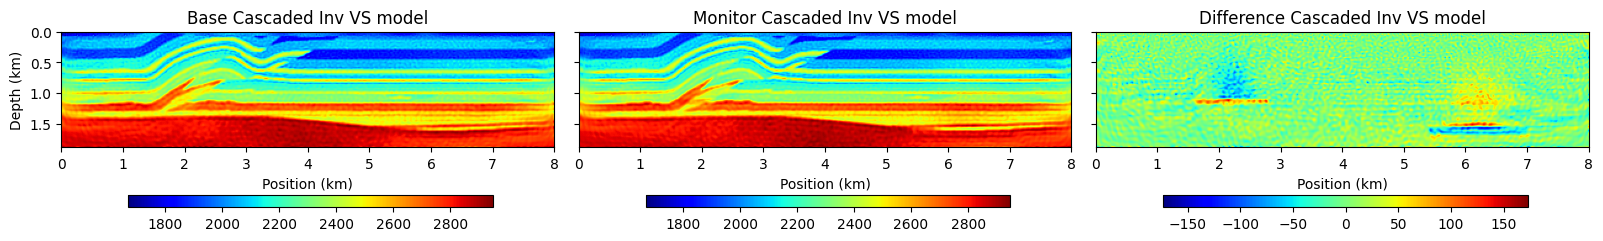

In [57]:
plot_base_monitor(base_inv_vs.cpu().numpy(), monitor_inv_vs, np.array(dx)/1000, parameter='Cascaded Inv VS', diff=300/np.sqrt(3))

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/ElasticSiameseFWI-pub/utils/utils.py:839: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


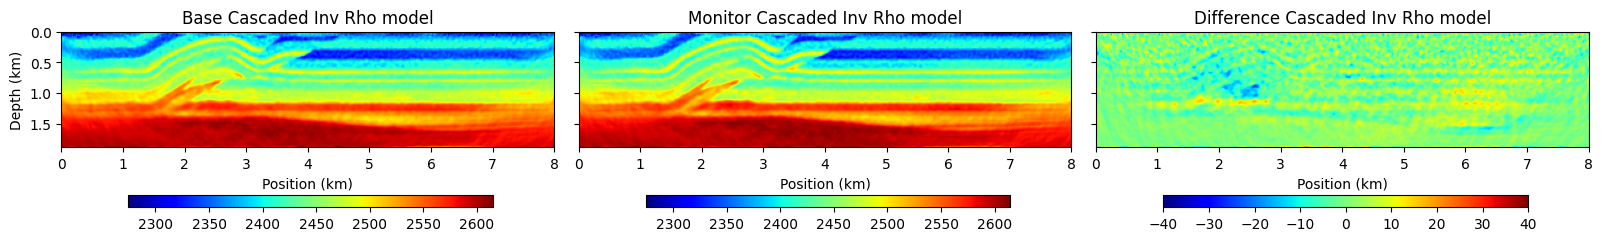

In [59]:
plot_base_monitor(base_inv_rho, monitor_inv_rho, np.array(dx)/1000, parameter='Cascaded Inv Rho', diff=40)